# Data Exploration

## Setup

In [112]:
import hub
import numpy as np
import pandas as pd
import time
from scipy import signal
from matplotlib import pyplot as plt
from IPython import display
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
ds = hub.load("hub://activeloop/nsynth-test")
print("\n")
print("Opened access to NSynth. Sample Entry:")
print(ds)
print("\n")
print(f"There are {ds.instrument.shape[0]} audio samples of size {ds.audios.shape[1]}.")
print(f"The dataset has around {ds.audios.shape[0] * ds.audios.shape[1] * 64 / 8e9} gb of data.")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/nsynth-test loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/nsynth-test.


Opened access to NSynth. Sample Entry:
Dataset(path='hub://activeloop/nsynth-test', read_only=True, tensors=['audios', 'sample_rate', 'pitch', 'instrument_source', 'instrument_family', 'note', 'qualities', 'velocity', 'instrument'])


There are 4096 audio samples of size 64000.
The dataset has around 2.097152 gb of data.


## Visualize some data

In [4]:
N = 10
print(f"Try loading {N} data samples:")
start_t = time.time()
audio = ds.audios[:N].numpy()
end_t = time.time()
size = audio.itemsize * audio.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 10 data samples:
Loaded 0.00512 gb of data in 6.162098169326782 seconds


In [5]:
print(f"Try loading {N} data labels:")
start_t = time.time()
labels = ds.instrument_family[:N].numpy().astype('int32').reshape(-1)
end_t = time.time()
size = labels.itemsize * labels.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 10 data labels:
Loaded 4e-08 gb of data in 0.45952510833740234 seconds


In [6]:
sample_rate = ds.sample_rate[0].numpy()[0]

In [7]:
instruments = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']
instrument_index = dict([(v,i) for i, v in enumerate(instruments)])

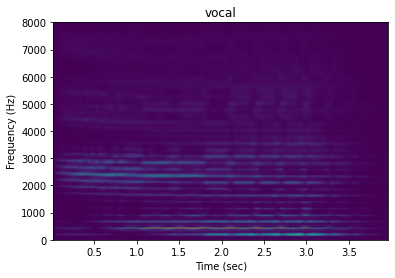

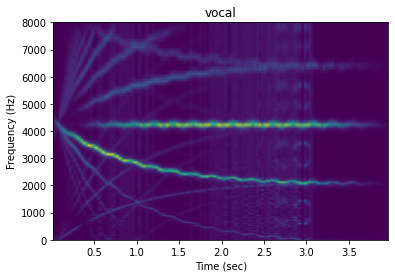

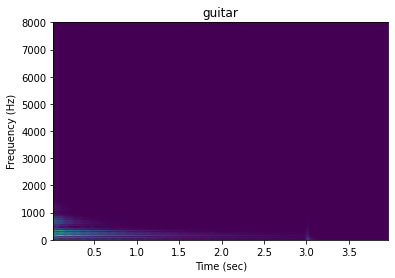

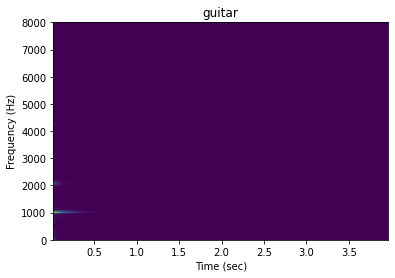

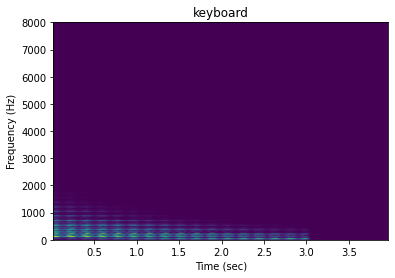

In [81]:
def clean_samples(samples):
    return samples.reshape((samples.shape[0], samples.shape[1])).astype('float32')


def fft(sample, sample_rate, window_size=512, n_mels=None):
    """Create the Spectrogram.
    
    This returns an three arrays F (frequency), T (time), and S (spectrogram).
    The entry S[f,t] is the magnitude of frequency F[f] (in Hz) at time T[t] (in seconds).
    """
    f, t, s = signal.spectrogram(sample, fs=sample_rate, nperseg=window_size, mode='magnitude')
    if n_mels is not None:
        n_fft = (s.shape[-2]-1)*2
        melfb = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels, fmax=f[-1])
        s = melfb @ s
        f = librosa.mel_frequencies(n_mels, fmax=f[-1])
    return f, t, s


def visualize(f, t, s, instrument):
    plt.pcolormesh(t, f, s, shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title(instrument)
    plt.show()

def fft_visualize(sample, label, sample_rate, window_size=512, n_mels=None):
    visualize(*fft(sample, sample_rate, window_size=window_size, n_mels=n_mels), instruments[label])

samples = clean_samples(audio)

number_to_show = 5

for i in range(number_to_show):
    fft_visualize(samples[i], labels[i], sample_rate, n_mels=128)
    show_audio = display.Audio(samples[i], rate=sample_rate)
    display.DisplayHandle().display(show_audio)

## Construct a subset of the dataset

In [69]:
def select_new_subset(selected_families, instruments_per_family=2, examples_per_instrument=None, verbose=True):
    """Pick a subset of the dataset by selecting random indices.
    
    The for each instrument family (keyboards, guitars, etc), there are many instruments.
    For each instrument (piano, harpsichord, clavinet), there are many samples.
    Each sample is one data point.
    
    This function extracts the indices of samples from randomly chosen instruments from
    the specificied selected instrument families.
    
    Params:
        selected_families: the codes for the instrument families to draw instruments from
        instruments_per_family: how many instruments per family to draw samples from
        examples_per_instrument: how many samples to draw per instrument
        
    Returns:
        a dictionary with keys:
            indices: the indices of the selected samples displayed as a flat array
            [instrument family code]:
                [instrument code]: a list of indices corresponding to the samples for this instrument
    """
    instrument_families = ds.instrument_family.numpy().astype('int32').reshape(-1)
    instruments = ds.instrument.numpy().astype('int32').reshape(-1)
    indices = np.arange(instruments.shape[0])
    selection = {
        'indices': np.array([]).astype(np.int32)
    }
    all_selected_instruments = set()
    for family in selected_families:
        if verbose:
            print("Get instruments for family ", family)
        instrument_codes = np.unique(instruments[instrument_families == family])
        print(instrument_codes)
        selected_instruments = np.random.choice(instrument_codes, instruments_per_family, replace=False)
        selection[family] = {}
        
        for inst in selected_instruments:
            if verbose:
                print("Get samples for instrument ", inst)
            n = examples_per_instrument
            instrument_indices = indices[instruments == inst]
            if n is None:
                n = instrument_indices.shape[0]
            selected_samples = np.random.choice(instrument_indices, n, replace=False)
            selection[family][inst] = selected_samples
            selection['indices'] = np.concatenate([selection['indices'], selected_samples])
    return selection


def load_selection(selection, selection_subset_size=None, verbose=True):
    """Loads a dataset from the selected subset given by `selection`.
    
    selection_subset_size is used for debugging.
    
    Returns:
        dataframe with columns [id, instrument_family, instrument, audio]
    """
    if selection_subset_size is None:
        selection_subset_size = selection['indices'].shape[0]
    indices = list(np.sort(selection['indices']))[:selection_subset_size]
    instrument_families = ds.instrument_family[indices].numpy().astype('int32').reshape(-1)
    instruments = ds.instrument[indices].numpy().astype('int32').reshape(-1)
    pitches = ds.pitch[indices].numpy().reshape(-1)
    if verbose:
        print(f"Load {len(indices)} samples")
    audio = clean_samples(ds.audios[indices].numpy())
    if verbose:
        print("Finished loading")
    df = pd.DataFrame({'id': indices, 'instrument_family': instrument_families, 'instrument': instruments, 'pitch': pitches})
    df['audio'] = list(audio)
    df = df.astype({'id': 'int64', 'instrument_family': 'int64', 'instrument': 'int64', 'audio': object, 'pitch': 'int64'})
    return df


selected_families = [instrument_index['keyboard']]
selection = select_new_subset(selected_families, instruments_per_family=8)
print(f"Selected {selection['indices'].shape} samples...")

Get instruments for family  4
[ 40  50  65 327 577 805 838 905]
Get samples for instrument  838
Get samples for instrument  50
Get samples for instrument  905
Get samples for instrument  805
Get samples for instrument  577
Get samples for instrument  327
Get samples for instrument  40
Get samples for instrument  65
Selected (766,) samples. Preparing to load the audio...


In [71]:
df_raw = load_selection(selection, selection_subset_size=None)
df_raw

Load 766 samples
Finished loading


,id,instrument_family,instrument,audio
0,4,4,65,"[-3.0517578e-05, -0.0009460449, -0.0018310547,..."
1,12,4,65,"[0.0004272461, 0.0007019043, 0.0010070801, 0.0..."
2,14,4,805,"[-0.0034179688, -0.0056152344, -0.0051574707, ..."
3,19,4,838,"[0.0, 0.0, 0.0, 3.0517578e-05, -6.1035156e-05,..."
4,26,4,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
761,4083,4,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
762,4084,4,577,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
763,4085,4,327,"[0.00579834, 0.0038146973, -0.004425049, -0.00..."
764,4093,4,905,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00024414062, ..."


In [93]:
class Audio:
    def __init__(self, f, t, s, audio, sample_rate):
        self.f = f
        self.t = t
        self.s = s
        self.audio = audio
        self.sr = sample_rate
        
    def visualize(self):
        fig, ax = plt.subplots()
        ax.pcolormesh(self.t, self.f, self.s, shading='gouraud')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')
        return fig, ax
    
    def play(self):
        show_audio = display.Audio(self.audio, rate=self.sr)
        display.DisplayHandle().display(show_audio)


def create_spectrograms(df, sample_rate, window_size=512):
    df = df.copy()
    audio = np.vstack(df['audio'])
    f, t, s = fft(audio, sample_rate, window_size=window_size, n_mels=128)
    
    spectrograms = [Audio(f, t, s[i], audio[i], sample_rate) for i in range(s.shape[0])]
    df['audio'] = spectrograms
    return df, s

df, s = create_spectrograms(df_raw, sample_rate)
df

,id,instrument_family,instrument,audio
0,4,4,65,<__main__.Audio object at 0x7effd1b9e280>
1,12,4,65,<__main__.Audio object at 0x7efffb581b20>
2,14,4,805,<__main__.Audio object at 0x7efffb581190>
3,19,4,838,<__main__.Audio object at 0x7effd19ba820>
4,26,4,40,<__main__.Audio object at 0x7efffb7d6ee0>
...,...,...,...,...
761,4083,4,40,<__main__.Audio object at 0x7efffb558430>
762,4084,4,577,<__main__.Audio object at 0x7efffb558490>
763,4085,4,327,<__main__.Audio object at 0x7efffb5584f0>
764,4093,4,905,<__main__.Audio object at 0x7efffb558550>


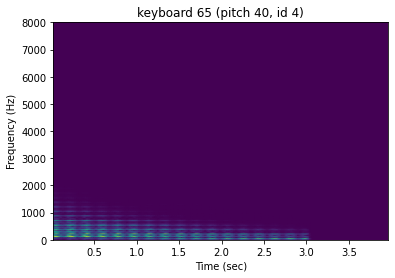

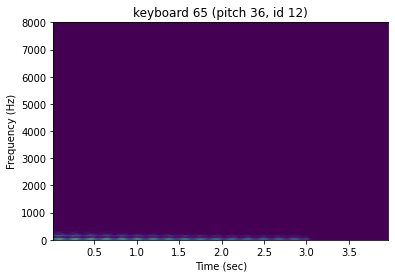

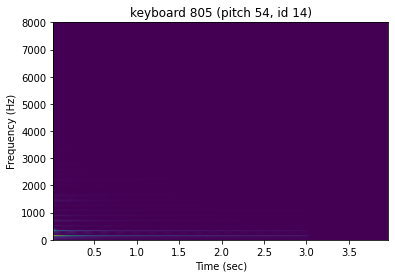

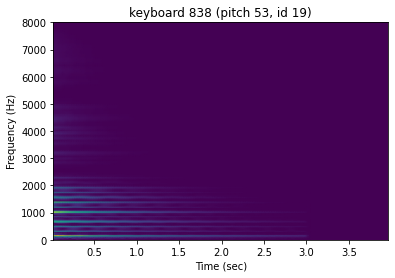

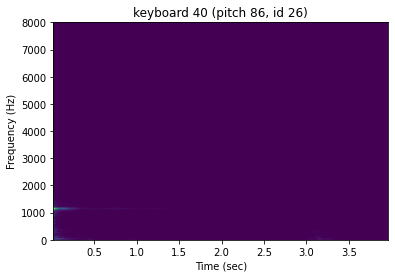

In [191]:
num_to_visualize = 5
for i in range(num_to_visualize):
    spectrogram = df.iloc[i]['audio']
    fig, ax = spectrogram.visualize()
    instrument_family = instruments[df.iloc[i]['instrument_family']]
    instrument = df.iloc[i]['instrument']
    ax.set_title(f"{instrument_family} {instrument} (pitch {df.iloc[i]['pitch']}, id {df.iloc[i]['id']})")
    plt.show(fig)
    spectrogram.play()

## Construct training data

In [217]:
def instrument_code_to_ordinal(y):
    codes = np.unique(y)
    y_encoded = y.copy()
    lookup = dict([(code, i) for i, code in enumerate(codes)])
    for code in codes:
        y_encoded[y == code] = lookup[code]
    return y_encoded

# make a teeny tiny subset
df_small = df[df.instrument.isin([838, 805]) & (df.pitch == 51)]
tiny_indices = df_small.index.to_numpy()
s2 = s[tiny_indices]
print(s.shape)
print(s2.shape)

X = s2.reshape((s2.shape[0], 1, s2.shape[1], s2.shape[2]))
y = instrument_code_to_ordinal(df_small['instrument'].to_numpy().astype(np.int64))
print(X.shape)
print(y.shape)

trainloader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=4, shuffle=True)

(766, 128, 142)
(4, 128, 142)
(4, 1, 128, 142)
(4,)


## Train a quick torch model

In [234]:
class Clf(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding='same', stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8, 16, 5, padding='same', stride=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same', stride=1)
        self.fc1 = nn.Linear(32*16*17, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        # (64x8704 and 288x64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def predict(self, X):
        X = torch.tensor(X)
        scores = self.forward(X).detach().numpy()
        return np.argmax(scores, axis=1)
    
def get_accuracy(y1, y2):
    return (y1 == y2).mean()

In [ ]:
softmax = nn.CrossEntropyLoss()
optimizer = optim.SGD(clf.parameters(), lr=0.1) # momentum=0.9)

clf = Clf(2)

print("Start Training...")
losses = []
epochs = 500
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = clf.forward(inputs)
        loss = softmax(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    losses.append(loss.detach().numpy())

print("finished!")
plt.plot(np.arange(epochs), losses)

y_pred = clf.predict(X)
print(get_accuracy(y, y_pred))

Start Training...
